<a href="https://colab.research.google.com/github/blajiness/CHE_7530-Assignments/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>Assignment 4 - MSE7530, Fall 2025

<font size=4>The physical focus of this assignment will be X-ray scattering from non-crystalline materials. The Python focus will be the SciPy.special module, linear fitting, and optimization with SciPy.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [32]:
!rm -r MSE7530
! git clone https://github.com/cbishop4/MSE7530/

Cloning into 'MSE7530'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 262 (delta 55), reused 4 (delta 4), pack-reused 165 (from 1)
Receiving objects: 100% (262/262), 10.30 MiB | 24.24 MiB/s, done.
Resolving deltas: 100% (116/116), done.


<font size=4><font color='blue'> Homework Questions are at the Bottom of the Document. Nothing before the section "Questions for Homework" will be graded.

# Python Primers
<font size=4> These concepts will be used in the X-ray scattering material. While most of the code is written for you, it is important to understand how these functions work.

## Scipy.special (and Scipy.constants)

### scipy.special

SciPy has many scientific equations pre-loaded to make our lives easier. Take, for example, equation 4.23 in Als-Nielsen & McMorrow for scattering from a sphere of radius r.

<font size=4>$\mathcal{F}(Q) = \frac{1}{V_{p}}\int_0^R\int_0^{2\pi}\int_0^\pi e^{iQrcos~\theta}r^{2}sin~\theta d\theta d\phi dr$  


<font size=4>$ = \frac{1}{V_{p}}\int_0^R 4\pi \frac{sin(Qr)}{Qr}r^2dr$  


<font size=5>$ = 3[\frac{sin(QR) - QRcos(QR)}{Q^{3}R^{3}}] \equiv \frac{3J_{1}(QR)}{QR}$

<font size=4>Where $J_{1}(x)$ is the Bessel function of the first kind. Bessel functions are solutions to Bessel's ordinary differential equation.  They are often used when solving problems in cylindrical and spherical systems. Therefore, they show up often in scientific computing and SciPy has them built in. First,


```
from scipy import special
```



In [33]:
from scipy import special

Then, we can use the special scipy functions as we do later, when we calculate form factor scattering.

### scipy.constants
While we are not going to use it in this notebook, it's worth mentioning that scipy has a module for scientific constants (https://docs.scipy.org/doc/scipy/reference/constants.html). Here we import it:

In [34]:
from scipy import constants as spc

It has many constants, from common scientific quantities (e.g., Planck's constant) to conversion factors. Here are a couple examples. Of course you never have to use these, because you can insert numbers manually, but it could be helpful in the future.

In [35]:
print(f'scipy.constants has Plancks constant: {spc.h}')
print(f'it also has this conversion from eV to Joules: {spc.eV}')

scipy.constants has Plancks constant: 6.62607015e-34
it also has this conversion from eV to Joules: 1.602176634e-19


## Numpy.random
The numpy.random module can be used to generate random numbers, random distributions, etc. To make things reproducible, you generally need to start with a seed. In this notebook, I will use the random module for you.  
In this notebook, I have used the "legacy" random generation. They have changed the way to do this that will be most supported in code in the future; however, this way still works for current code, and it is how I learned it, so for now I am using it. Documentation is here: https://numpy.org/doc/2.1/reference/random/legacy.html

## Scipy.optimize & Scipy.stats
<font size=4>The optimize module of SciPy is one of the most useful ones you will use. It allows fitting data to any user-defined for built-in function. This ranges from least-squares optimization to Global optimization. We will also use the specific linear regression function in scipy.stats. The three functions are:

```
from scipy import stats
from scipy import optimize

# then what we will use

stats.linregress(x, y)
optimize.curve_fit(func, x, y)
optimize.differential_evolution(func, bounds)
```




<font size=4>See the documentation for each:  
The first two should be possible to follow. Both have worked examples; try the examples and become familiar with the principles, even if it's just copy-pasting the example cells.  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

<font size=4>"Differential Evolution" can be more of a black box for now. Briefly read the documentation, and skim the wikipedia page.  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
https://en.wikipedia.org/wiki/Differential_evolution


# Form factor Scattering

## Plotting scattering from analytical particle morphologies
<font size=4>As described in the textbook, there are only* 3 particle shapes that it is possible to analytically describe form factor scattering: spheres, discs, and rods. Below are the 3 equations entered as user-defined functions, using the Bessel and sine integral functions from the scipy.special module.

<font size=4>For a sphere:  
$\mathcal{F}(Q) = \frac{1}{V_{p}}\int_0^R\int_0^{2\pi}\int_0^\pi e^{iQrcos~\theta}r^{2}sin~\theta d\theta d\phi dr$  


<font size=4>$ = \frac{1}{V_{p}}\int_0^R 4\pi \frac{sin(Qr)}{Qr}r^2dr$  


<font size=5>$ = 3[\frac{sin(QR) - QRcos(QR)}{Q^{3}R^{3}}] \equiv \frac{3J_{1}(QR)}{QR}$

<font size=4> For some reason I am having trouble with the SciPy Bessel function. It does not match what is plotted in the book. Therefore, for the scattering from a sphere, I have just copied the explicit formula in 4.23 rather than using the Bessel. This does cause some doubt for discs and rods; however, for now let's not worry too much about this.  
<font size=4><font color='red'> **Extra credit**: Find what's wrong with the Bessel function representation commented out here. Maybe try looking in the book at equation 4.23 and working it out by hand. If appropriate, change the disc and rod equations to be consistent with your understanding of the Bessel.

In [36]:
# def FQ2_sphere(radius, q): # scipy Bessel function is not reproducing correct result; what's happening?
#   return (3*special.jv(1,q*radius) / (q*radius))**2
def FQ2_sphere(radius, q):
  return (3*((np.sin(q*radius)- q*radius*np.cos(q*radius)))/(q**3 * radius**3))**2
def FQ2_disc(radius, q):
  return 2 * (1 - (special.jv(1,2*q*radius)/(q*radius)) ) / (q**2 * radius**2)
def FQ2_rod(length, q):
  term1 = (2*special.sici(q*length)[0]) / (q * length)
  term2 = (4 * (np.sin(q*length/2))**2) / (q**2 * length**2)
  return term1 - term2 # I just broke this into two terms to avoid a huge return line

First, let's use these to make a similar graph to Figure 4.14 in the textbook.

Text(0.5, 1.0, 'Form factor scattering from different shapes')

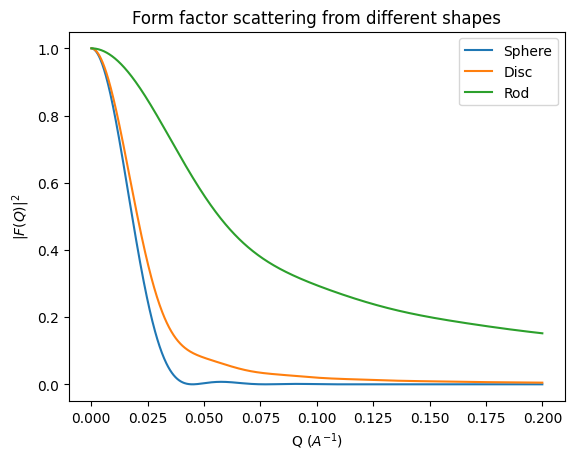

In [37]:
dimension = 100.
qrange = np.linspace(0.0001, 0.2,1000)
fig, ax = plt.subplots()

ax.plot(qrange, FQ2_sphere(dimension,qrange),label='Sphere')
ax.plot(qrange, FQ2_disc(dimension,qrange),label='Disc')
ax.plot(qrange, FQ2_rod(dimension,qrange),label='Rod')
ax.legend()
ax.set_xlabel('Q ($A^{-1}$)')
ax.set_ylabel('$|F(Q)|^{2}$')
ax.set_title('Form factor scattering from different shapes')

Note that the above is a bit different than what's in the book; below we use the table to convert the x-axis to $QR_{g}$ like the figure in the book

(0.0, 1.1)

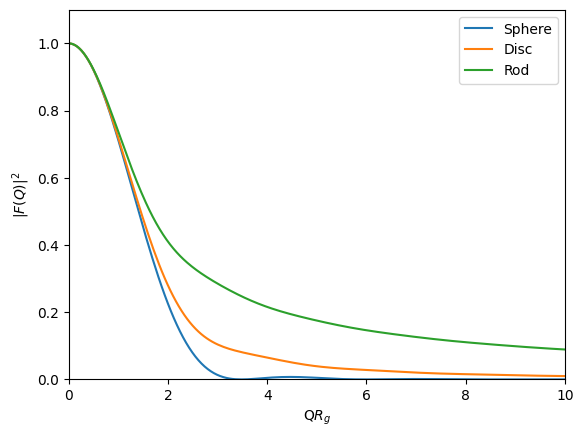

In [38]:
dimension = 100.
qrange = np.linspace(0.0001, .8,1000) # make the q-range a bit longer
QRg_sph = qrange*dimension*(3/5)**.5 # note the 3 different formulas for Rg in the table
QRg_disc = qrange*dimension*(0.5)**0.5
QRg_rod = qrange*dimension*(1/12)**0.5
fig, ax = plt.subplots()
ax.plot(QRg_sph, FQ2_sphere(dimension,qrange),label='Sphere')
ax.plot(QRg_disc, FQ2_disc(dimension,qrange),label='Disc')
ax.plot(QRg_rod, FQ2_rod(dimension,qrange),label='Rod')
ax.legend()
ax.set_xlabel('Q$R_{g}$')
ax.set_ylabel('$|F(Q)|^{2}$')
ax.set_xlim(0,10); ax.set_ylim(0,1.1)

## Effect of radius on the form factor for different shapes

Text(0.5, 1.0, 'Rod (length)')

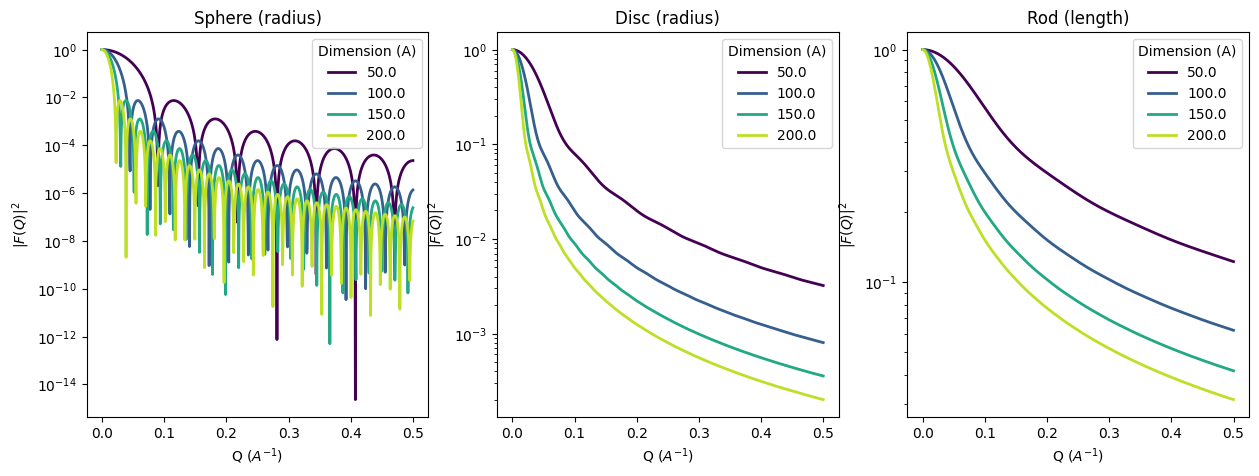

In [39]:

fig, ax = plt.subplots(1,3,figsize=(15,5))
qrange = np.linspace(0.0001, .5,1000)
radii = [50., 100., 150., 200.]
pcol = iter(cm.viridis(np.linspace(0.,.9,len(radii))))
for r in radii:
  cc = next(pcol)
  ax[0].plot(qrange, FQ2_sphere(r,qrange),label=r,color=cc,linewidth=2)
  ax[1].plot(qrange, FQ2_disc(r,qrange),label=r,color=cc,linewidth=2)
  ax[2].plot(qrange, FQ2_rod(r,qrange),label=r,color=cc,linewidth=2)

for a in ax:
  a.semilogy()
  a.legend(title='Dimension (A)')
  a.set_xlabel('Q ($A^{-1}$)')
  a.set_ylabel('$|F(Q)|^{2}$')
ax[0].set_title('Sphere (radius)'); ax[1].set_title('Disc (radius)'); ax[2].set_title('Rod (length)')

## Guinier & Porod Analysis

<font size=4> As seen from the above, it is pretty easy to manually inspect the form factor scattering for a sphere and extract the radius by hand. However, it is much harder for discs and rods. Let's pull out the Rgs by Guinier analysis and compare to the dimensions we made the curves with. To do this we will need to:  
1. Change the axes to be appropriate for Guinier analysis  
2. Identify the proper range in which the Guinier approximation holds
3. Linearly fit the data and find the slope; compare with the known Rg

### Guinier analysis

#### Example 1: Sphere with dimension 100.0 Angstroms

Step 1: Calculate "experimental" scattering and transform axes

Text(0.5, 1.0, 'Zoom-in of plot 2')

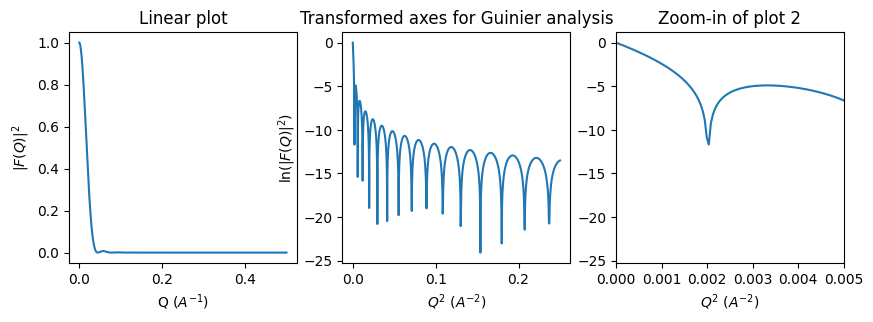

In [40]:
# calculate the scattering for the sphere with R = 100.0 Angstroms.
# we will call this the "experimental scattering"
fig, ax = plt.subplots(1,3,figsize=(10,3))
qrange = np.linspace(0.0001, .5,1000)
r = 100.0
experimental_FQ2 = FQ2_sphere(r,qrange)
ax[0].plot(qrange, experimental_FQ2,label=r)
ax[0].set_xlabel('Q ($A^{-1}$)'); ax[0].set_ylabel('$|F(Q)|^{2}$')
# to do Guinier analysis, we need to plot on an ln I vs Q^2 plot
q2 = qrange**2
lnI = np.log(experimental_FQ2) # note that "np.log" is the natural log, while np.log10 is the base 10 log
for a in [ax[1],ax[2]]:
  a.plot(q2,lnI,label=r)
  a.set_xlabel('$Q^{2}~(A^{-2})$'); ax[1].set_ylabel('ln($|F(Q)|^{2}$)')

ax[2].set_xlim(0, 0.005)
ax[0].set_title('Linear plot'); ax[1].set_title('Transformed axes for Guinier analysis')
ax[2].set_title('Zoom-in of plot 2')


Step 2. Identify Guinier range. By visual inspection, it seems clear that by $Q^{2} = 0.002 A^{-2}$, we are well-past a linear regime. What $QR$ does this correspond to? Let's also identify a "safely" linear regime, which we'll say ends at 0.001.

In [41]:
print(f' Linear approximation ends around {0.001 * r} to {0.002 * r}QR')

 Linear approximation ends around 0.1 to 0.2QR


Since no explicit value of QR is given in the textbook, this is a decent number for us to see. Keep it in mind for the future and see if it always holds (I'm not sure).

Step 3. Linear Fit.  
Here we will use the scipy.stats linear regression function. There are several different ways you can do linear fits in Python, but this one is good because it gives statistics.

In [42]:
# import the stats module where linregress is
from scipy import stats

Text(0, 0.5, 'ln($|F(Q)|^{2}$)')

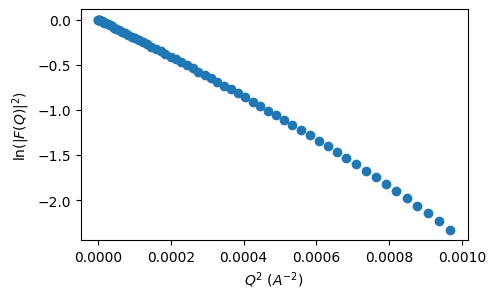

In [43]:
# first we need to cut our range to the purely linear regime
linear_indices = np.where(q2 < 0.001) # picks all the indices where q2 is less than 0.001
# the reason we must do this is that we need to choose those same indices from 2 arrays
linear_q2 = q2[linear_indices]
linear_lnI = lnI[linear_indices]
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(linear_q2,linear_lnI,'o')
ax.set_xlabel('$Q^{2}~(A^{-2})$'); ax.set_ylabel('ln($|F(Q)|^{2}$)')

We can see that this is not exactly linear the whole way through; maybe we want to use a smaller range. Exactly how small you cut it, in reality, depends on your data density.

In [44]:
lin_result = stats.linregress(linear_q2,linear_lnI)
lin_result

LinregressResult(slope=np.float64(-2325.8122678423692), intercept=np.float64(0.03510985399671018), rvalue=np.float64(-0.9986980593742371), pvalue=np.float64(1.4992132632982796e-80), stderr=np.float64(15.210543005220742), intercept_stderr=np.float64(0.006679512803234993))

<font size=4>The result from the above code is a slope of -2325.8. The r-value (measure of how close to a straight line) is -0.9987. The other statistical measures are printed next to it.

<font size=4>Now we convert to R using the relationship that for a **sphere** the slope of the $ln I$ vs. $Q^{2}$ plot is equal to $-\frac{R^{2}}{5}$

In [45]:
slope = lin_result[0]
R = np.sqrt(-5 * slope)
R

np.float64(107.83812562916627)

<font size=4>We got out a value for R that is 107.8 Angstroms, which is roughly the radius that we used to generate the data. Perhaps the disagreement is due to the non-linearity we saw as we got near 0.001; let's try cutting it at 0.0002

<font size=4>Note that the slope is equal to **R**, not **Rg**. To convert the slope to Rg (in the case of an idealized particle) use the formulae provided in table 4.2.

 R is equal to 101.31570504685571


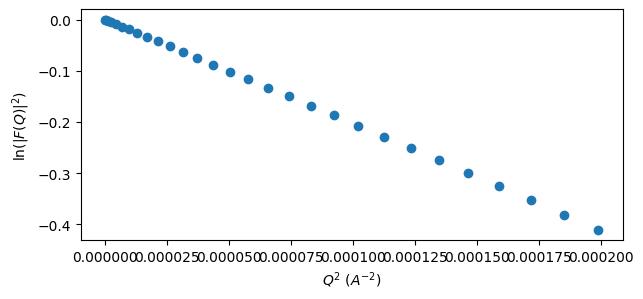

In [46]:
linear_indices = np.where(q2 < 0.0002)
linear_q2 = q2[linear_indices]
linear_lnI = lnI[linear_indices]
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(linear_q2,linear_lnI,'o')
ax.set_xlabel('$Q^{2}~(A^{-2})$'); ax.set_ylabel('ln($|F(Q)|^{2}$)')
lin_result = stats.linregress(linear_q2,linear_lnI)
lin_result
slope = lin_result[0]
R = np.sqrt(-5 * slope)
print(f' R is equal to {R}')

Now R is equal to 101.3 Angstroms, which is pretty close to our particle radius. Here I will make an equation to automatically return the slope so we can see the effect of cutting that regime.

In [47]:
def find_slope_sphere(q2max, q_square, ln_I):
  ''' An equation to find the sphere radius for a chosen value of the
    upper limit of the Guinier region

    Args:
      q2max (float) : the upper limit which you want to use for the Guinier region
      q_square (numpy array, floats) : the squared scattering vector
      ln_I (numpy array, floats) : the natural log of intensities (should be
      the same length and from the same dataset as q_square)

    Returns:
      R (float) : the spherical radius obtained from the Guinier fit
      rval (float) : the r-value for the fit
  '''
  linear_indices = np.where(q_square < q2max)
  linear_q2 = q_square[linear_indices]
  linear_lnI = ln_I[linear_indices]
  lin_result = stats.linregress(linear_q2,linear_lnI)
  slope = lin_result[0]
  rval = lin_result[2]
  R = np.sqrt(-5 * slope)
  return R, rval # this way we also get an estimate of how linear the fit is

Text(0.0015, 102, 'Actual R')

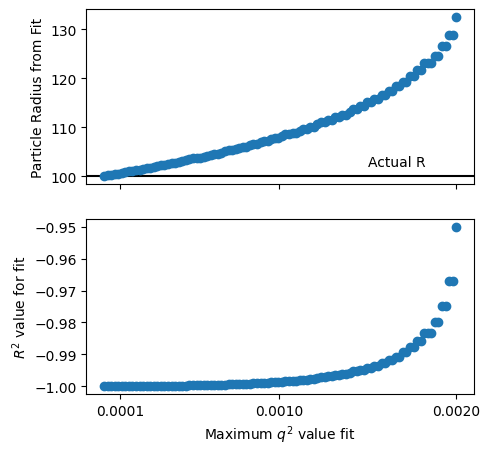

In [48]:
qmaxes = np.linspace(0.00001, 0.002,100)
calc_rad = []
Rvals = []
for qmax in qmaxes:
  R, rval = find_slope_sphere(qmax, q2, lnI)
  calc_rad.append(R)
  Rvals.append(rval)
fig, ax = plt.subplots(2,1,figsize=(5,5),sharex=True)
ax[0].axhline(100.,color='k')
ax[0].plot(qmaxes, calc_rad,'o')
ax[1].plot(qmaxes, Rvals,'o')
ax[1].set_xlabel('Maximum $q^{2}$ value fit')
ax[0].set_ylabel('Particle Radius from Fit')
ax[1].set_ylabel('$R^{2}$ value for fit')
for a in ax:
  a.set_xticks([0.0001,0.001,0.002])
ax[0].text(0.0015,102,'Actual R')


<font size=4>As we can see, the smallest q-region we can fit (with sufficient signal-to-noise, in the case of experimental data) will give us the most accurate value for R.

### Porod analysis.
<font size=4> See homework questions at the end for practice doing Porod analysis. You will follow the same steps as with the Guinier analysis, just with different axes and equations.

## Polydispersity
<font size=4> In the textbook, the function for calculating polydispersity is given by  
$I(Q) = \Delta \rho^{2} \int_{0}^{\infty} D(R)V_{p}(R)^{2}|\mathcal{F}(Q,R)|^{2} ~ dR $

<font size=4> We can calculate this by summing multiple form factors. Take that for a sphere:

[]

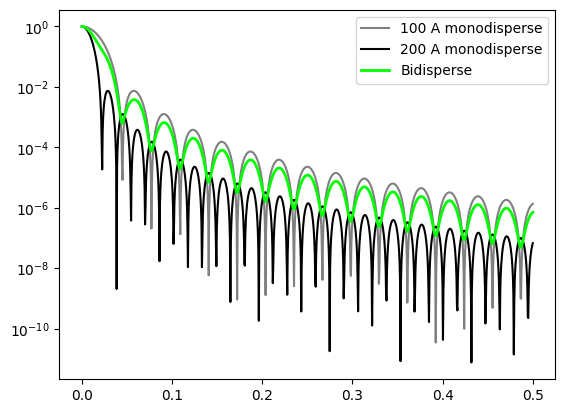

In [49]:
mono100 = FQ2_sphere(100.,qrange)
plt.plot(qrange,mono100,label='100 A monodisperse',color='grey')
mono200 = FQ2_sphere(200.,qrange)
plt.plot(qrange,mono200,label='200 A monodisperse',color='black')
bidisperse = (mono100 + mono200)/2
plt.plot(qrange,bidisperse,label='Bidisperse',color='lime',linewidth=2)
plt.legend()
plt.semilogy()

<font size=4> With increasing polydispersity, we very quickly smear out the scattering. Let's do this for 8 particle sizes:

Text(0.5, 1.0, '8 particle sizes, 50-800 nm')

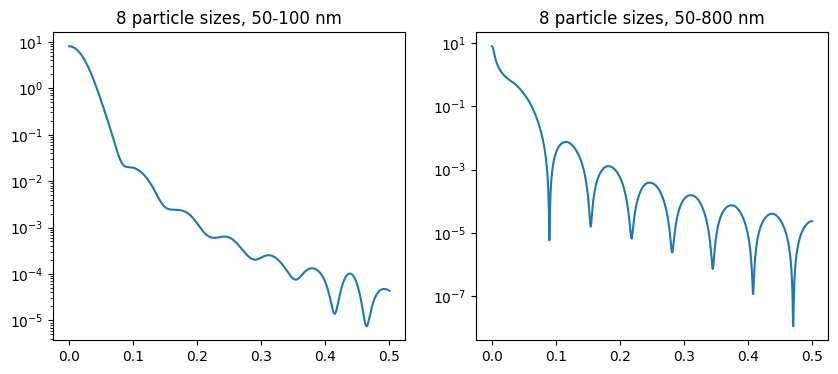

In [50]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
particle_sizes = np.linspace(50.,100.,8)
scatter = np.zeros(len(qrange))
for p in particle_sizes:
  scatter += FQ2_sphere(p, qrange)
# now the same number of particle sizes, but a larger dispersity
scatter2 = np.zeros(len(qrange))
particle_sizes2 = np.linspace(50.,800.,8)
for p in particle_sizes2:
  scatter2 += FQ2_sphere(p, qrange)

ax[0].plot(qrange,scatter)
ax[1].plot(qrange,scatter2)
for a in ax:
  a.semilogy()
ax[0].set_title('8 particle sizes, 50-100 nm')
ax[1].set_title('8 particle sizes, 50-800 nm')


### Pulling more realistic distributions (+ Python skills)  
<font size=4> To make a more realistic solution, we will pull particle sizes from a normal distribution. To do this, we will use the NumPy random module. (https://numpy.org/doc/2.1/reference/random/generated/numpy.random.normal.html)

<font size=4>A Gaussian is defined by the equation for the probability distribution $p(x)$:  
<font size=4>$p(x) = \frac{1}{\sqrt{2\pi \sigma ^{2}}} e^{- \frac{(x - \mu)^{2}}{2 \sigma ^{2}}} $

<font size=4>We can use the np.random.normal function to choose a specified number of random numbers pulled with that probability. If we pull a sufficient number of samples, it should look like a Gaussian. Below we pull 3 different distributions with the same mean ($\mu$ above, given by the parameter "loc" in the code) and standard deviation ($\sigma$ above, given by "scale"), but with increasing numbers of samples (in code, "size") to see the effect of sampling on the generated distribution. After generating each, we plot a histogram of the values.

Text(0.5, 1.0, '10,000 samples')

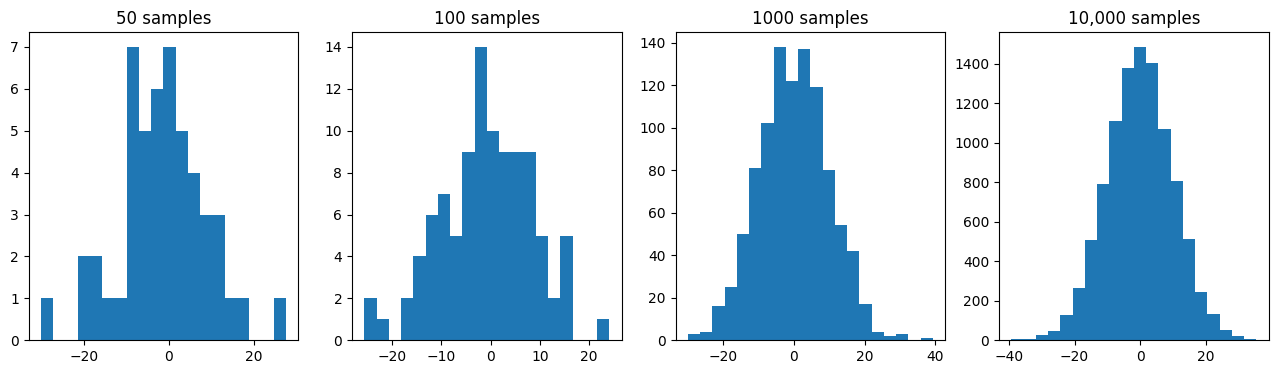

In [51]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
distro1 = np.random.normal(loc=0, scale=10, size=50)
distro2 = np.random.normal(loc=0, scale=10, size=100)
distro3 = np.random.normal(loc=0, scale=10, size=1000)
distro4 = np.random.normal(loc=0, scale=10, size=10000)
ax[0].hist(distro1,bins=20)
ax[1].hist(distro2,bins=20)
ax[2].hist(distro3,bins=20)
ax[3].hist(distro4,bins=20)
ax[0].set_title('50 samples')
ax[1].set_title('100 samples')
ax[2].set_title('1000 samples')
ax[3].set_title('10,000 samples')

Note that if you run the cell above multiple times, the results change. To make the results from a single notebook/script reproducible, we can use a "random seed". This sets the random generator to a specified state so that every time you run the notebook, it will generate random numbers reproducibly. **You should always do this when you use a random function**.


```
np.random.seed(seed=30)
```



Text(0.5, 1.0, '10,000 samples')

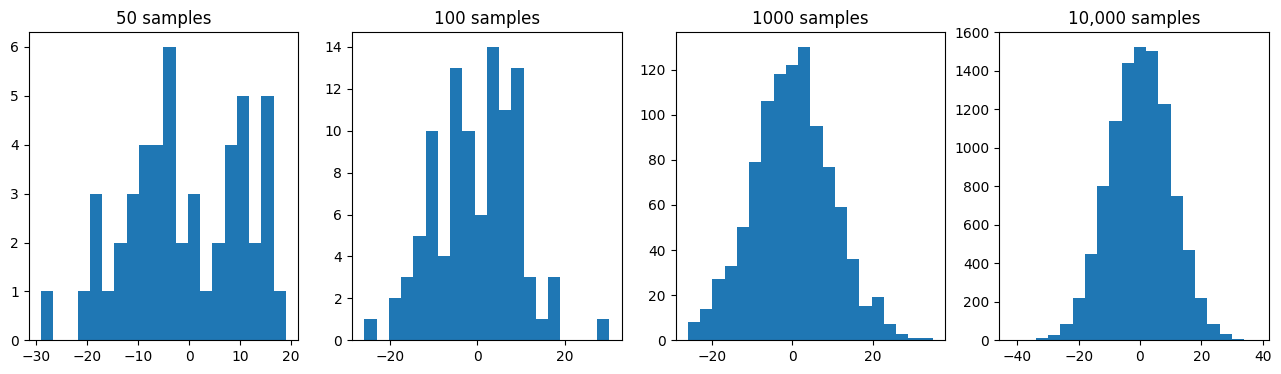

In [52]:
np.random.seed(seed=30)
fig, ax = plt.subplots(1,4,figsize=(16,4))
distro1 = np.random.normal(loc=0, scale=10, size=50)
distro2 = np.random.normal(loc=0, scale=10, size=100)
distro3 = np.random.normal(loc=0, scale=10, size=1000)
distro4 = np.random.normal(loc=0, scale=10, size=10000)
ax[0].hist(distro1,bins=20)
ax[1].hist(distro2,bins=20)
ax[2].hist(distro3,bins=20)
ax[3].hist(distro4,bins=20)
ax[0].set_title('50 samples')
ax[1].set_title('100 samples')
ax[2].set_title('1000 samples')
ax[3].set_title('10,000 samples')

Now, it will make the same distributions every time so you can exactly reproduce results from everyone's notebooks

<font size=4> Applying the distribution to polydispersity.  
Different processes (for example, polymerizations) can lead to different distributions of particle sizes in solution. Different distributions can lead to nearly identical scattering, so you will often need complementary characterization.

Text(0, 0.5, '$|F(Q)|^{2}$')

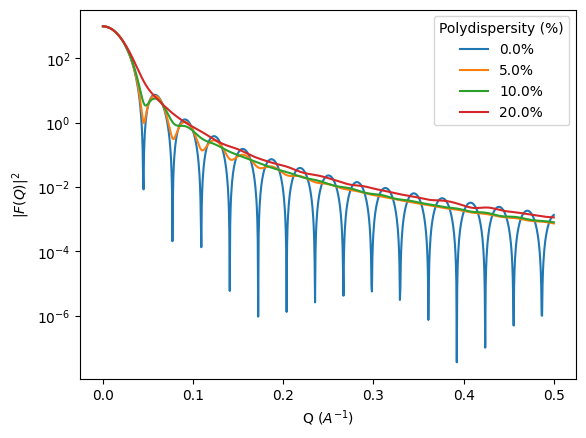

In [53]:
fig, ax = plt.subplots()
dispersities = np.asarray([0., .05, .1, .2])

radius = 100.
for d in dispersities:
  np.random.seed(seed=30)
  particle_sizes = np.random.normal(loc=radius, scale=radius*d, size=1000)
  scatter = np.zeros(len(qrange))
  for p in particle_sizes:
    scatter += FQ2_sphere(p, qrange)
  ax.plot(qrange,scatter, label=f'{d*100}%')

ax.semilogy()
ax.legend(title='Polydispersity (%)')
ax.set_xlabel('Q ($A^{-1}$)')
ax.set_ylabel('$|F(Q)|^{2}$')


Text(0.5, 1.0, 'Bi-modal system')

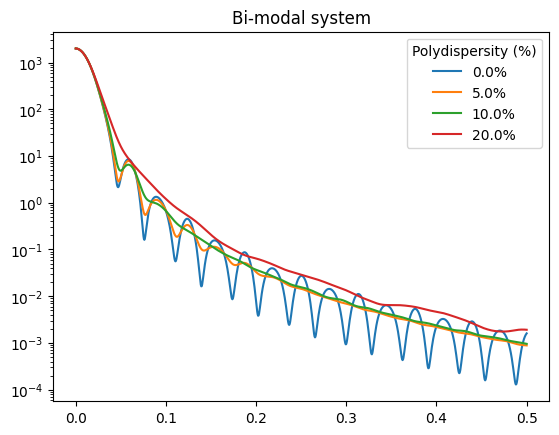

In [54]:
fig, ax = plt.subplots()
dispersities = np.asarray([0., .05, .1, .2])
radius1 = 100.
radius2 = 150.
for d in dispersities:
  np.random.seed(seed=50)
  particle_sizes1 = np.random.normal(loc=radius1, scale=radius1*d, size=1000)
  particle_sizes2 = np.random.normal(loc=radius2, scale=radius1*d, size=1000)
  all_particles = np.append(particle_sizes1,particle_sizes2)
  scatter = np.zeros(len(qrange))
  for p in all_particles:
    scatter += FQ2_sphere(p, qrange)
  ax.plot(qrange,scatter, label=f'{d*100}%')

ax.semilogy()
ax.legend(title='Polydispersity (%)')
ax.set_title('Bi-modal system')

<font size=4> Polydispersity can make it quite difficult to find unique solutions. One way to more powerfully search for real-space solutions is with a genetic algorithm, which you will do later in the homework questions.

# Questions for Homework
<font size=4> Only work below this line will be graded. For each question, I have inserted a code and/or text line. If there is a code line, it is expected that you show your work with code; if a text line, a written explanation is required. You can always add cells if you want to put more into your explanation.

## 1) Guinier Analysis for a Disc with $R = 150.0 ~Å$.  
(Hint: A lot of this can be done by copy-pasting code from the walkthrough)

### a. Generate a graph of $|F(Q)|^{2}$ vs Q.

Text(0, 0.5, '$|F(Q)|^{2}$')

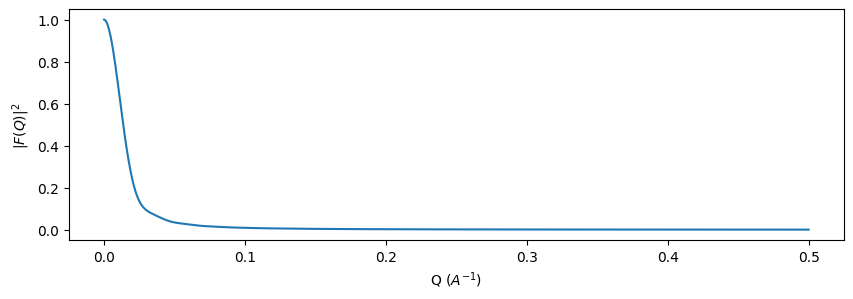

In [103]:
# code here
fig, ax = plt.subplots(1,1,figsize=(10,3))
qrange = np.linspace(0.0001, .5,1000)
r = 150.0
experimental_FQ2 = FQ2_disc(r,qrange)
ax.plot(qrange, experimental_FQ2,label=r)
ax.set_xlabel('Q ($A^{-1}$)'); ax.set_ylabel('$|F(Q)|^{2}$')



### b. Show the Guinier analysis on your generated scattering to recover your original $R$.

Text(0, 0.5, 'ln($|F(Q)|^{2}$)')

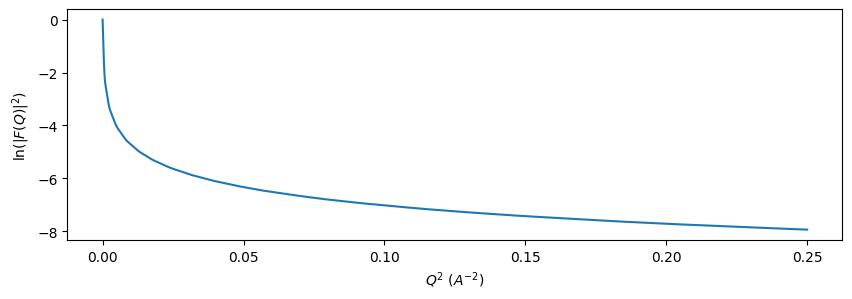

In [104]:
# code here
fig, ax = plt.subplots(1,1,figsize=(10,3))
# to do Guinier analysis, we need to plot on an ln I vs Q^2 plot
q2 = qrange**2
lnI = np.log(experimental_FQ2) # note that "np.log" is the natural log, while np.log10 is the base 10 log
#for a in [ax[0]]:
ax.plot(q2,lnI,label=r)
ax.set_xlabel('$Q^{2}~(A^{-2})$'); ax.set_ylabel('ln($|F(Q)|^{2}$)')


In [105]:
print(f' Linear approximation ends around {0.001 * r} to {0.002 * r}QR')

 Linear approximation ends around 0.15 to 0.3QR


Text(0, 0.5, 'ln($|F(Q)|^{2}$)')

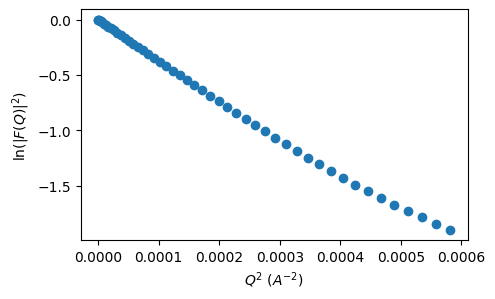

In [108]:
# first we need to cut our range to the purely linear regime
linear_indices = np.where(q2 < 0.0006) # picks all the indices where q2 is less than 0.001
# the reason we must do this is that we need to choose those same indices from 2 arrays
linear_q2 = q2[linear_indices]
linear_lnI = lnI[linear_indices]
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(linear_q2,linear_lnI,'o')
ax.set_xlabel('$Q^{2}~(A^{-2})$'); ax.set_ylabel('ln($|F(Q)|^{2}$)')

In [109]:
lin_result = stats.linregress(linear_q2,linear_lnI)
lin_result
slope = lin_result[0]
R = np.sqrt(-5 * slope)
R

np.float64(130.3834455544571)

 R is equal to 136.34299273518366


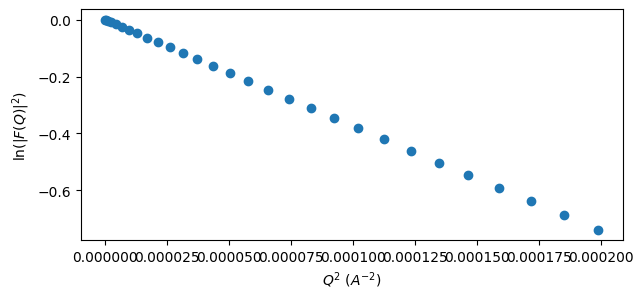

In [110]:
linear_indices = np.where(q2 < 0.0002)
linear_q2 = q2[linear_indices]
linear_lnI = lnI[linear_indices]
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(linear_q2,linear_lnI,'o')
ax.set_xlabel('$Q^{2}~(A^{-2})$'); ax.set_ylabel('ln($|F(Q)|^{2}$)')
lin_result = stats.linregress(linear_q2,linear_lnI)
lin_result
slope = lin_result[0]
R = np.sqrt(-5 * slope)
print(f' R is equal to {R}')

### c. Show the fitting of the Porod exponent for your generated scattering.

In [57]:
# code here

## 2) **7530 only**: From a dilute solution of spheres with the following polydispersities:  
 - 50 percent $ ~R = 100. ~Å$, and 50 percent $ ~R = 200. ~Å$
 - 9.09 percent each $ ~R = 100., 110., 120., ... 200. $
 - 10 percent $ ~R = 90.$, 10 percent $R = 110.$, 10 percent $R = 190.$, 10 percent R = 210., 30 percent $R = 100.$, and 30 percent $R = 200.$

 For all of the following exercises, you may continuously copy-paste code, or you may write functions to simplify the process.

### a) Generate $|F(Q)|^{2}$ vs. Q for the three distributions, and plot them on the same graph.

In [58]:
# code here

### b) Find the Guinier slope for your 3 distributions. Are they the same or different?

In [59]:
# code here

<font color='red'> [Written Answer Here]

### c) Find the Porod exponent for your 3 distributions. Are they the same or different?

In [60]:
# code here

<font color='red'> [Written Answer Here]

### d) Consider your answers to parts a-c. Using SAXS, can you differentiate between distributions of polydispersity even if the mean particle size is the same? If so, how?

<font color='red'> [Written Answer Here]

## 3) SIBYLS beamline.  
<font size=4>There is a beamline called SIBYLS at Lawrence Berkeley National Laboratory that combines Size Exclusion Chromatography with SAXS. A description of the experimental setup can be found in this publication (https://pubmed.ncbi.nlm.nih.gov/36410949/), which you don't have to read to answer this question, but might be helpful. Why is size exclusion chromatography important to combine with SAXS to analyze polydisperse solutions?

<font color='red'> [It can seperate out the different factions of non-homogenous sizes leaving parts of the colum having pieces with roughly the same size]

## 4) The Small Angle Scattering Biological Databank  
<font size=4> This database holds SAXS and SANS data on many biomolecules. For the following questions, the relevant I vs. q profiles have been loaded into the class GitHub repository. The links are provided for your reference.

### a) For the ABC transporter ATP-binding protein (SASDW27 - https://www.sasbdb.org/data/SASDW27/), find the $R_{g}$ by fitting in Python. I have provided the code to get the data from the Github.

In [115]:
import pandas as pd
ABC_data = pd.read_csv('/content/MSE7530/sampledata/HW4/SASDW27.dat', sep=' ',header=3)# this data will be deposited in Github
ABC_data = ABC_data.rename(columns={ABC_data.columns[1]: 'q', ABC_data.columns[3]: 'I', ABC_data.columns[5]: 'myst' })
ABC_data = ABC_data.drop(['Unnamed: 0', 'Unnamed: 2', 'Unnamed: 4', 'myst'],axis=1)
# the code above is weird and unorthodox; the important thing is that you now have a
# dataframe with q and I data.
from scipy.optimize import curve_fit

In [62]:
ABC_data

,q,I
0,0.088611,134.72050
1,0.093763,136.11620
2,0.098915,134.75740
3,0.104067,133.75190
4,0.109219,129.06520
...,...,...
690,3.643503,0.72894
691,3.648655,1.19346
692,3.653807,0.66934
693,3.658959,0.34712


In [111]:
# code here
# I could not figure out how to do this without chatgpt helping with code
def guinier(q, I0, Rg):
    return I0 * np.exp(-q**2 * Rg**2 / 3)

In [113]:
q = ABC_data['q'].to_numpy()
I = ABC_data['I'].to_numpy()

In [129]:
# Select Guinier region (adjust indices as necessary)
q_guinier = q[:50]  # First 20 data points
I_guinier = I[:50]

# Fit Guinier model
popt, pcov = curve_fit(FQ2_sphere, q_guinier, I_guinier, p0=[np.max(I_guinier), 5.0])
I0_fit, Rg_fit = popt

# Calculate Rg from the fit
Rg_calculated = np.sqrt(Rg_fit)

TypeError: FQ2_sphere() takes 2 positional arguments but 3 were given

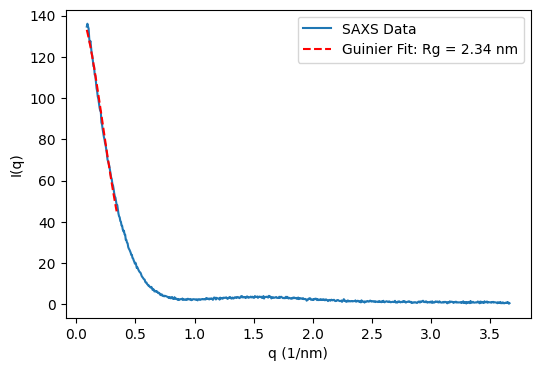

In [124]:
plt.figure(figsize=(6, 4))
plt.plot(q, I, label='SAXS Data')
plt.plot(q_guinier, guinier(q_guinier, *popt), 'r--', label=f'Guinier Fit: Rg = {Rg_calculated:.2f} nm')
plt.xlabel('q (1/nm)')
plt.ylabel('I(q)')
plt.legend()
plt.show()

<font color='red'> [Rg = 2.34nm 20.34 Å]

### b) The reported $V^{Porod}$ on the website is $735 ~nm^{3}$. What is the corresponding surface area for this protein? (Hint: we did not cover this calculation explicitly in class, but the step is shown in the notes, and the equation is explicitly given in Als-Nielsen & McMorrow chapter 4.

In [128]:
# code here
Vp = 735.0  # nm^3
Rg = 2.34   # nm
Sp = Vp**2 / ((4 * np.pi / 9) * Rg**4)
print('The corresponding surface area is', Sp)

The corresponding surface area is 12904.580583494215


<font color='red'> [12904.58 nm^2]

### c) Visit the "About SASBDB" page. To what extent does SASBDB follow FAIR data principles? You must address each of the four principles in your answer.

<font color='red'> [Written Answer Here]

## 5) Differential Evolution Walkthrough.
<font size=4> You do not need to modify any code in this walkthrough. However, your turned in notebook should have outputs showing that you ran through the cells.

<font size=4> This will follow a very similar workflow to a "simulated experiment" in crease. The question we will answer here is: Given a scattering pattern, can we uniquely find the radius and polydispersity at the same time?

<font size=4> "Simulated Experiment" - Generating our objective function ($I_{exp} (q)$).

Text(0.5, 0, 'Q ($A^{-1}$)')

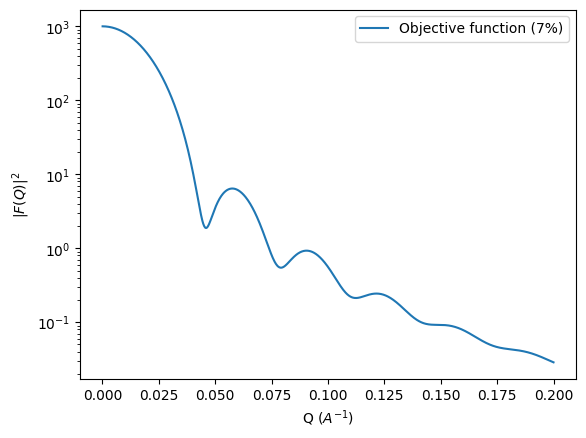

In [65]:
# prepare the "known" scattering
fig, ax = plt.subplots()
qrange = np.linspace(0.0001, 0.2,1000)
dispersity=0.07
radius = 100.
particle_sizes = np.random.normal(loc=radius, scale=radius*dispersity, size=1000)
I_exp = np.zeros(len(qrange))
for p in particle_sizes:
    I_exp += FQ2_sphere(p, qrange)
ax.plot(qrange,I_exp,label='Objective function (7%)')

ax.semilogy()
ax.legend()
ax.set_ylabel('$|F(Q)|^{2}$')
ax.set_xlabel('Q ($A^{-1}$)')

<font size=4> Setting up the genetic algorithm (differential evolution).
As an argument, differential_evolution takes some function to optimize. In this case, the function:
1. Generates a range of particle sizes from a specified radius and polydispersity percentage. "Loc" corresponds to the mean size of particles in the distribution, and the "scale" corresponds to the full-width at half-max of the distribution.  
2. The "for p in particle_sizes:" loop calculates the form factor scattering for each sphere in the distribution and sums it together into $I_{comp}$.
3. The "MSE" step calculates the error between the experimental (what we simulated) and the current guess data. Note that I have done this on the $log_{10}$ data; it wasn't converging when I did it linearly.

In [66]:
def gen_scatter(x):
  ''' A function that calculates the MSE for simulated scattering from a
      specified radius and polydispersity and compares it to known scattering

      Args:
        x (array or list) : a list of parameters corresponding to [radius, polydispersity]

      Returns:
        MSE (float) : the mean squared error between the simulated and known scattering
  '''
  np.random.seed(42) # seed so we have the same scattering every time
  qrange = np.linspace(0.0001, 0.2,1000)
  dispersity=0.07
  radius = 100. # these are for our I_exp
  particle_sizes = np.random.normal(loc=radius, scale=radius*dispersity, size=1000)
  I_exp = np.zeros(len(qrange))
  for p in particle_sizes:
      I_exp += FQ2_sphere(p, qrange)
  # the next line is what we will randomly generate in each step of the GA evaluation
  particle_sizes = np.random.normal(loc=x[0], scale=x[0]*x[1], size=1000)
  I_comp = np.zeros(len(qrange))
  for p in particle_sizes:
      I_comp += FQ2_sphere(p, qrange)
  MSE = np.mean((np.log10(I_comp) - np.log10(I_exp))**2)
  print(f'{x[0]}, {x[1]}, {MSE}')
  return MSE

<font size=4> Now we will run our differential evolution (a type of genetic algorithm). Below I set it up. Be reassured that it should take 1-3 minutes to run.

In [67]:
from scipy import optimize

In [68]:
pd_min, pd_max = 0.06, 0.08 # sets the upper and lower bounds on polydispersities to test
r_min, r_max = 50., 300. # sets maximum and minimum mean particle radius
bounds = [(r_min,r_max),(pd_min,pd_max)]
np.random.seed(10)
result4 = optimize.differential_evolution(gen_scatter, bounds, tol = 0.01)

192.42049457725756, 0.0682893426622222, 1.2755909076905827
84.7425903046878, 0.06973402596893637, 0.14274517429774358
153.68194312019165, 0.06272555987611601, 0.6007419852261469
291.56354562418227, 0.06552791737878043, 3.326117136211472
115.10517468043429, 0.06507501737788626, 0.11753987288785815
100.03290221939929, 0.07592262431970746, 0.0006071017278814606
252.7125969819354, 0.0690087588283696, 2.498075438235408
137.85453640009385, 0.07743410134642839, 0.3501233858944043
298.5510236986895, 0.06116586925502575, 3.486647029882801
226.65789616399007, 0.07611001059847944, 1.9393120681206528
244.1330142239973, 0.0730841914322076, 2.307107299395709
236.2637719952674, 0.07034776476826243, 2.1514073410603634
70.82089176918825, 0.06676144669840102, 0.41706859728211454
278.2009537391017, 0.07457123353497183, 3.0179004054045233
181.71019330693957, 0.07950091608947138, 1.041863662646825
208.72413599491043, 0.06778275574337757, 1.6016515151717108
172.08664318276223, 0.07862950714149254, 0.8682652

<font size=4> Unfortunately, it is actually quite difficult to print out the progress of a differential evolution during its evaluation. By hand, I copy-pasted the above printed results into excel, used "Text to Columns", saved the excel file, and uploaded it to the class repo. We retrieve it below so you can graphically see the results.

In [69]:
diffE_res4 = pd.read_excel('/content/MSE7530/sampledata/HW4/diffE_result4.xlsx',header=None, names=['R','PD','MSE'])

Text(0, 0.5, 'MSE')

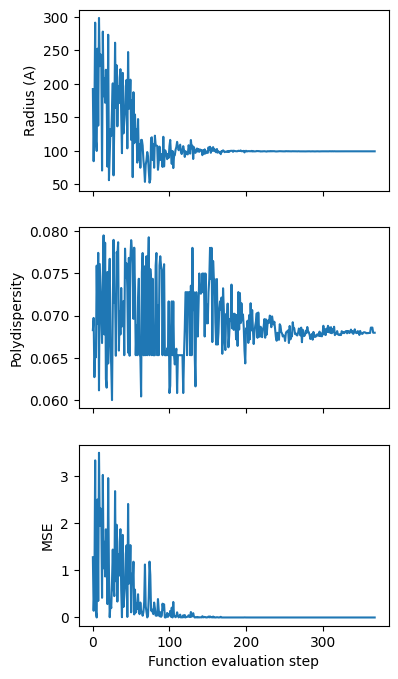

In [70]:
fig, ax = plt.subplots(3,1,figsize=(4,8),sharex=True)
ax[0].plot(diffE_res4['R'])
ax[1].plot(diffE_res4['PD'])
ax[2].plot(diffE_res4['MSE'])
ax[2].set_xlabel('Function evaluation step')
ax[0].set_ylabel('Radius (A)')
ax[1].set_ylabel('Polydispersity')
ax[2].set_ylabel('MSE')


Using our result (result4), we plot the fit results over the (simulated) experimental data.

Text(0.5, 0, 'Q ($A^{-1}$)')

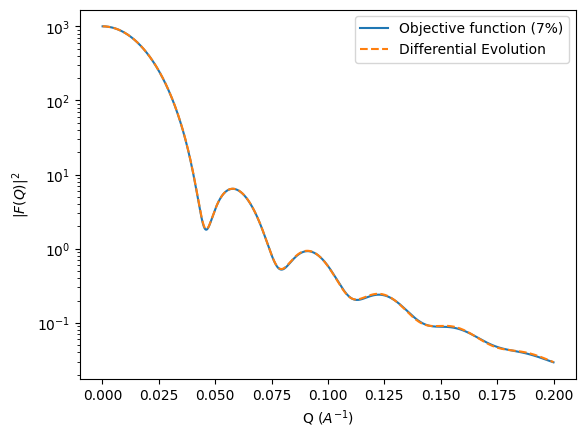

In [71]:
# prepare the "known" scattering
fig, ax = plt.subplots()
np.random.seed(42)
qrange = np.linspace(0.0001, 0.2,1000)
dispersity=0.07
radius = 100.
particle_sizes = np.random.normal(loc=radius, scale=radius*dispersity, size=1000)
I_exp = np.zeros(len(qrange))
for p in particle_sizes:
    I_exp += FQ2_sphere(p, qrange)
ax.plot(qrange,I_exp,label='Objective function (7%)')
particle_sizes = np.random.normal(loc=result4['x'][0], scale=result4['x'][0]*result4['x'][1], size=1000)
I_solved = np.zeros(len(qrange))
for p in particle_sizes:
    I_solved += FQ2_sphere(p, qrange)
ax.plot(qrange,I_solved,label='Differential Evolution',linestyle='--')


ax.semilogy()
ax.legend()
ax.set_ylabel('$|F(Q)|^{2}$')
ax.set_xlabel('Q ($A^{-1}$)')

### a) Which parameter - radius or polydispersity - has the biggest effect on the MSE? How can you tell from the graphs? Qualitatively, why does it have a bigger effect on the MSE?

<font color='red'> [Raidus seems have biggeset effect on the mse because the decrease in noise on MSE seems to decrease with the noise Raidus. The reason it has a bigger effect MSE is because Raidus is the basis for the polydiversity so it affects the mse both direcctly and indirecctly]

### b) Where does the fit seem to be the best - at low or high values of Q? Thinking about how error is calculated, why might this be?

<font color='red'> [Low Q, because the low has more well defined features meaning lower data varirence over ranges which is means better fit]

<font size=4><font color='red'> **Extra credit**: Find what's wrong with the Bessel function representation commented out in the initial walkthrough. Maybe try looking in the book at equation 4.23 and working it out by hand. If appropriate, change the disc and rod equations to be consistent with your understanding of the Bessel.

In [72]:
###